In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as tt

In [2]:
plt.style.use(['seaborn-darkgrid', 'seaborn-colorblind'])
sns.set_color_codes()
C0, C1 = sns.color_palette()[:2]

#### Code 11.1

In [3]:
TROLLEY_URI = 'https://raw.githubusercontent.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/master/Data/Trolley.csv'

trolley_df = pd.read_csv(TROLLEY_URI, sep=';')

In [4]:
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### Code 11.2

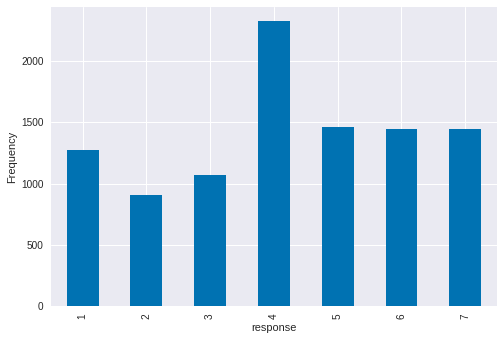

In [5]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .plot(kind='bar'))

ax.set_xlabel("response");
ax.set_ylabel("Frequency");

#### Code 11.3

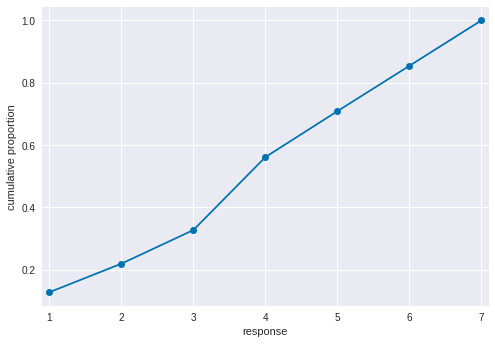

In [6]:
ax = (trolley_df.response
                .value_counts()
                .sort_index()
                .cumsum()
                .div(trolley_df.shape[0])
                .plot(marker='o'))

ax.set_xlim(0.9, 7.1);
ax.set_xlabel("response");

ax.set_ylabel("cumulative proportion");

#### Code 11.4

In [7]:
resp_lco = (trolley_df.response
                      .value_counts()
                      .sort_index()
                      .cumsum()
                      .iloc[:-1]
                      .div(trolley_df.shape[0])
                      .apply(lambda p: np.log(p / (1. - p))))

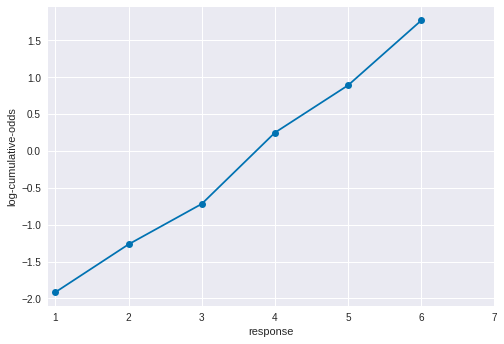

In [8]:
ax = resp_lco.plot(marker='o')

ax.set_xlim(0.9, 7);
ax.set_xlabel("response");

ax.set_ylabel("log-cumulative-odds");

#### Code 11.5 - 11.19

Not yet ported.

#### Code 11.20

In [9]:
# define parameters
PROB_DRINK = 0.2 # 20% of days
RATE_WORK = 1. # average 1 manuscript per day

# sample one year of production
N = 365

In [10]:
drink = np.random.binomial(1, PROB_DRINK, size=N)
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 11.21

In [11]:
drink_zeros = drink.sum()
work_zeros = (y == 0).sum() - drink_zeros

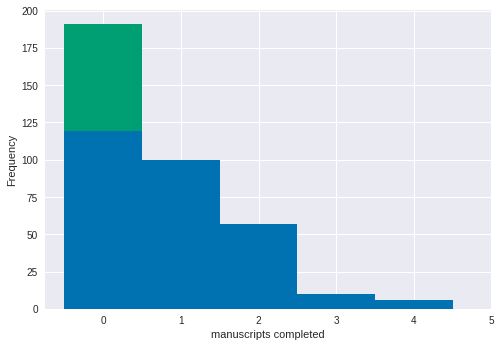

In [12]:
bins = np.arange(y.max() + 1) - 0.5

plt.hist(y, bins=bins);
plt.bar(0., drink_zeros, width=1., bottom=work_zeros, color=C1);

plt.xticks(bins + 0.5);
plt.xlabel("manuscripts completed");

plt.ylabel("Frequency");

#### Code 11.22

In [13]:
with pm.Model() as m11_4:
    ap = pm.Normal('ap', 0., 1.)
    p = pm.math.sigmoid(ap)
    
    al = pm.Normal('al', 0., 10.)
    lambda_ = tt.exp(al)
    
    y_obs = pm.ZeroInflatedPoisson('y_obs', 1. - p, lambda_, observed=y)

In [14]:
with m11_4:
    map_11_4 = pm.find_MAP()

logp = -452.59, ||grad|| = 64.082: 100%|██████████| 11/11 [00:00<00:00, 1175.83it/s]


In [15]:
map_11_4

{'al': array(0.001387055219947316), 'ap': array(-1.0668082549156876)}

#### Code 11.23

In [16]:
sp.special.expit(map_11_4['ap']) # probability drink

0.25601053955113379

In [17]:
np.exp(map_11_4['al']) # rate finish manuscripts, when not drinking

1.0013880176259575

#### Code 11.24

In [18]:
def dzip(x, p, lambda_, log=True):
    like = p**(x == 0) + (1 - p) * sp.stats.poisson.pmf(x, lambda_)
    
    return np.log(like) if log else like

#### Code 11.25

In [19]:
PBAR = 0.5
THETA = 5.

In [20]:
a = PBAR * THETA
b = (1 - PBAR) * THETA

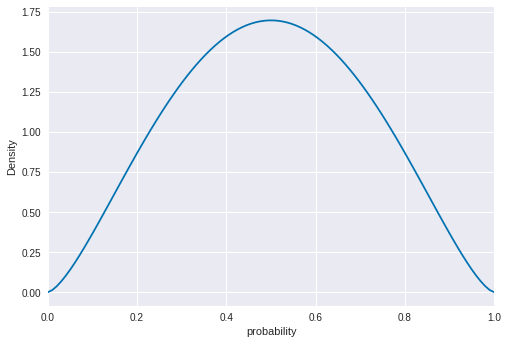

In [21]:
p = np.linspace(0, 1, 100)

plt.plot(p, sp.stats.beta.pdf(p, a, b));

plt.xlim(0, 1);
plt.xlabel("probability");

plt.ylabel("Density");

#### Code 11.26

In [22]:
ADMIT_URI = 'https://raw.githubusercontent.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/master/Data/UCBadmit.csv'

admit_df = pd.read_csv(ADMIT_URI, sep=';')

In [23]:
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [24]:
with pm.Model() as m11_5:
    a = pm.Normal('a', 0., 2.)
    pbar = pm.Deterministic('pbar', pm.math.sigmoid(a))

    theta = pm.Exponential('theta', 1.)
    
    admit_obs = pm.BetaBinomial(
        'admit_obs',
        pbar * theta, (1. - pbar) * theta,
        admit_df.applications.values,
        observed=admit_df.admit.values
    )

In [25]:
with m11_5:
    trace_11_5 = pm.sample(draws=3000, tune=1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [00:04<00:00, 828.33it/s]


#### Code 11.27

In [26]:
pm.df_summary(trace_11_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-0.377519,0.313642,0.004599,-0.977633,0.239128
pbar,0.408815,0.074173,0.001090,0.269480,0.555380
theta,2.761440,0.943105,0.014523,1.075413,4.631014


In [27]:
pm.effective_n(trace_11_5)

{'a': 4866.0, 'pbar': 4860.0, 'theta': 4960.0}

In [28]:
pm.gelman_rubin(trace_11_5)

{'a': 0.99983739986206677,
 'pbar': 0.99983351943927601,
 'theta': 0.99989238971130223}

#### Code 11.28

In [29]:
np.percentile(trace_11_5['pbar'], [2.5, 50., 97.5])

array([ 0.27050589,  0.40668136,  0.55670479])

#### Code 11.29

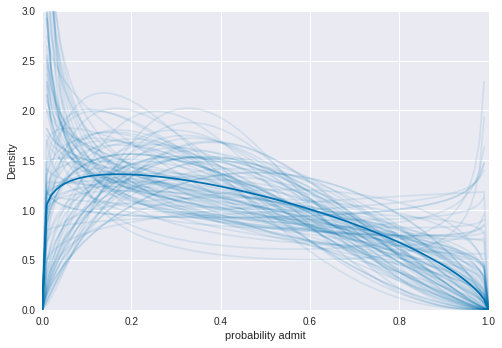

In [30]:
pbar_hat = trace_11_5['pbar'].mean()
theta_hat = trace_11_5['theta'].mean()

p_plot = np.linspace(0, 1, 100)

plt.plot(
    p_plot,
    sp.stats.beta.pdf(p_plot, pbar_hat * theta_hat, (1. - pbar_hat) * theta_hat)
);
plt.plot(
    p_plot,
    sp.stats.beta.pdf(
        p_plot[:, np.newaxis],
        trace_11_5['pbar'][:100] * trace_11_5['theta'][:100],
        (1. - trace_11_5['pbar'][:100]) * trace_11_5['theta'][:100]
    ),
    c=C0, alpha=0.1
);

plt.xlim(0., 1.);
plt.xlabel("probability admit");

plt.ylim(0., 3.);
plt.ylabel("Density");

#### Code 11.30

In [31]:
with m11_5:
    pp_trace_11_5 = pm.sample_ppc(trace_11_5)

100%|██████████| 3000/3000 [00:01<00:00, 1554.41it/s]


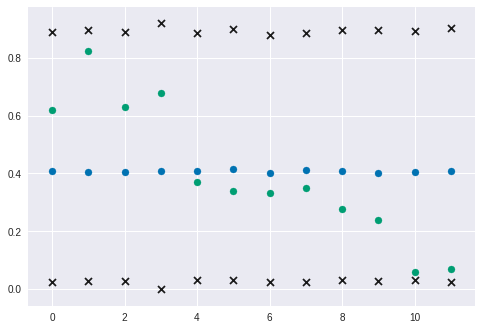

In [32]:
x_case = np.arange(admit_df.shape[0])

plt.scatter(
    x_case,
    pp_trace_11_5['admit_obs'].mean(axis=0) \
        / admit_df.applications.values
);
plt.scatter(x_case, admit_df.admit / admit_df.applications);

high = np.percentile(pp_trace_11_5['admit_obs'], 95, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, high, marker='x', c='k');

low = np.percentile(pp_trace_11_5['admit_obs'], 5, axis=0) \
        / admit_df.applications.values
plt.scatter(x_case, low, marker='x', c='k');

#### Code 11.31

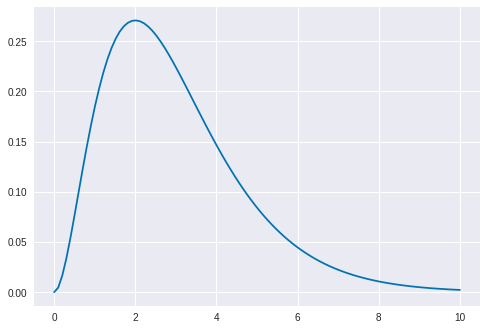

In [33]:
mu = 3.
theta = 1.

x = np.linspace(0, 10, 100)
plt.plot(x, sp.stats.gamma.pdf(x, mu / theta, scale=theta));